In [1]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2 as cv

In [2]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('.\\DATASET\\'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'Blank': 0, 'X Rotation': 1, 'Y Rotation': 2}

In [4]:
x_data = []
y_data = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for j in os.listdir('.\\DATASET\\'):
    if not j.startswith('.'):
        count = 0 # To tally images of a given gesture
        for k in os.listdir('.\\DATASET\\' + j+'\\'):
            img = Image.open('.\\DATASET\\' + j + '\\' + k).convert('RGB')
            img = img.resize((224, 224))
            arr = np.array(img)
            x_data.append(arr) 
            count = count + 1
        y_values = np.full((count, 1), lookup[j]) 
        y_data.append(y_values)
        datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
print(y_data.shape)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size
print("Y data:")
print(y_data.shape)
print("X data:")
print(x_data.shape)

(3, 500, 1)
Y data:
(1500, 1)
X data:
(1500, 224, 224, 3)


In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size = 0.2)
print(x_train.shape)
print(y_train.shape)

(1200, 224, 224, 3)
(1200, 1)


In [6]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255., 
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow(x_train,y_train, batch_size = 20)

validation_generator = test_datagen.flow(x_test,y_test, batch_size = 20)


j=train_generator.next()
print("X train: ")
print(j[0].shape)
print("Y train: ")
print(j[1].shape)

X train: 
(20, 224, 224, 3)
Y train: 
(20, 1)


In [7]:
from tensorflow.keras.applications import EfficientNetB0
base_model = EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [8]:

for layer in base_model.layers:
    layer.trainable = False

In [9]:
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Model

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
predictions = Dense(1, activation="sigmoid")(x)
model_final = Model(inputs = base_model.input, outputs = predictions)
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_a

 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
          

                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_s

 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_a

                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  10368       ['block7a_expand_activation[0][0]
 D)       

In [11]:
from tensorflow.keras.optimizers import RMSprop

model_final.compile(RMSprop(learning_rate=0.0001, decay=1e-6),loss='binary_crossentropy',metrics=['accuracy'])

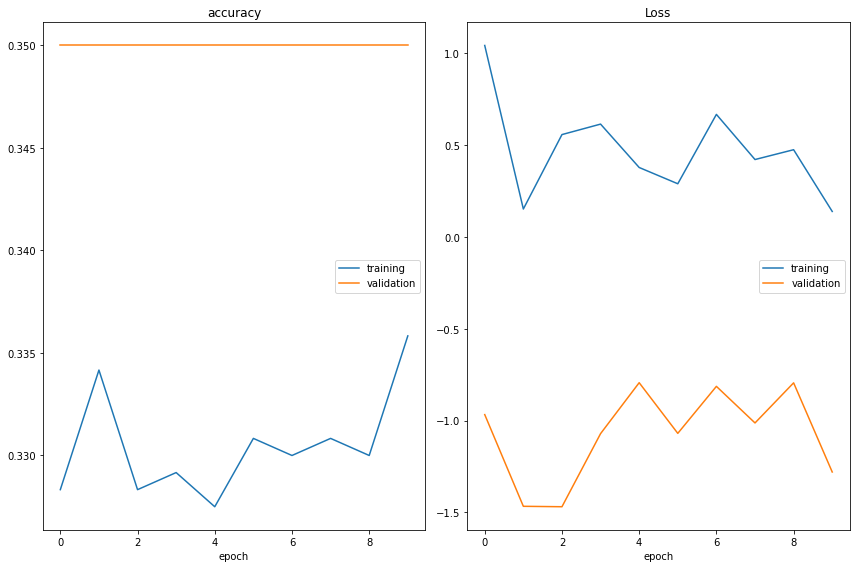

accuracy
	training         	 (min:    0.327, max:    0.336, cur:    0.336)
	validation       	 (min:    0.350, max:    0.350, cur:    0.350)
Loss
	training         	 (min:    0.139, max:    1.043, cur:    0.139)
	validation       	 (min:   -1.469, max:   -0.794, cur:   -1.280)
60/60 [==============================] - 63s 1s/step - loss: 0.1387 - accuracy: 0.3358 - val_loss: -1.2800 - val_accuracy: 0.3500


In [12]:
from livelossplot import PlotLossesKeras

eff_history = model_final.fit(train_generator,
                              validation_data = validation_generator,
                              callbacks=[PlotLossesKeras()], 
                              steps_per_epoch = 60,
                              epochs = 10,
                              verbose=1)

In [ ]:
model_final.save('my_model_1')